### Purpose of the Notebook

This notebook demonstrates how to use previous results to estimate recrystillization characteristics for new tungsten alloys with limited available data. The recrystilization experimental data published in [K. Tsuchida](https://www.sciencedirect.com/science/article/pii/S2352179117301886?via%3Dihub) for several tungsten alloys demonstrates a common situtation: Limited data is taken during an experiment to demonstrate the phenomonon of recrystillization, but not enough to fit the 2D function $X(t,T)$. To circumvent this issue, we can assume that that  the recrystilization of these tungtsten alloys follows the same latent model as obtained [previously](hierarchical_recystillization_inference.ipynb). This leaves us the problem only of obtaining $\overline{k}$ and $\overline{t}$ during inference. From these results, we have:

$$
p(\mathbf{c} | \mathcal{D}) = \int p(\mathbf{c},\mathbf{\overline{k}},\mathbf{\overline{t}} | \mathcal{D}) d \mathbf{\overline{k}} d \mathbf{\overline{t}}
$$

Which may be treated as a _prior_ for a _new_ data set $\mathcal{D}^{new} = \{(\mathbf{X,t,T})_{new}\} $ (which has only one set). We want to estimate $\overline{k},\overline{t}$ for this data set, formally stated:

$$
p(\overline{k}^{new},\overline{t}^{new} , \xi | \mathcal{D}^{new}, \text{previous} \ p(\mathbf{c} | \mathcal{D}))
$$

Where $\xi$ is an (additive) model error term. From Baye's rule:

$$
p(\overline{k}^{new},\overline{t}^{new}, \xi, \mathbf{c} | \mathcal{D}^{new}, \mathcal{D}) \propto \mathcal{L}(\mathcal{D}^{new} | \mathbf{c},\overline{k}^{new},\overline{t}^{new}, \xi) \times p(\mathbf{c} | \mathcal{D}) \pi(\overline{k}^{new},\overline{t}^{new} | \mathbf{c})
$$

where $\pi(\overline{k}^{new},\overline{t}^{new} , \xi | \mathbf{c}) = \pi(\overline{k}^{new}) \pi(\overline{t}^{new}) \pi(\xi) $ due to [_apriori_ independence](hierarchical_recystillization_inference.ipynb).

Which leaves:

$$
p(\overline{k}^{new},\overline{t}^{new}, \xi, \mathbf{c} | \mathcal{D}^{new}, \mathcal{D}) \propto \mathcal{L}(\mathcal{D}^{new} | \mathbf{c},\overline{k}^{new},\overline{t}^{new}) \times p(\mathbf{c} | \mathcal{D}) \pi(\overline{k}^{new}) \pi(\overline{t}^{new}) \pi(\xi) 
$$

and finally we can marginalize this posterior to obtain the desired result:

$$
p(\overline{k}^{new},\overline{t}^{new} | \mathcal{D}^{new}, \mathcal{D}) = \int p(\overline{k}^{new},\overline{t}^{new}, \xi, \mathbf{c} | \mathcal{D}^{new}, \mathcal{D}) d \mathbf{c} d\xi
$$


With the definition for likelihood given by either the JMAK or the GL model following gaussian errors (developed [here](hierarchical_recystillization_inference.ipynb)).

In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

from typing import Tuple,List, Dict, Callable

#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
sys.path.append(str(PARENT_DIR))

from common_util import setup_axis_default 

import numpyro
from numpyro.distributions import Normal,Exponential, MultivariateNormal,Distribution, Uniform, TruncatedNormal
from jax import numpy as jnp
import pickle
from jax import random
import jax.numpy as jnp
from numpyro.infer import init_to_mean, init_to_value
rng_key = random.PRNGKey(92)
rng_key, rng_key_ = random.split(rng_key)
from typing import Any

"""
Link files to tungsten alloy using hash tables
"""
_LABEL_TO_TEMPERATURE_FILE = {'Pure W': 'tschudia_data_Pure W data.csv',
                              'K-doped W': 'tschudia_data_K-doped W data.csv',
                              'K-doped 3%Re W': 'tschudia_data_K-doped 3%Re W data.csv'}

_LABEL_TO_TIME_FILE = {'Pure W': 'tschudia_data_T_1100CPure W Data.csv',
                       'K-doped W': 'tschudia_data_T_1100CK-doped W Data.csv',
                          'K-doped 3%Re W': 'tschudia_data_T_1100CK-doped W-3Re Data.csv'}


def _parse_temperature_file_label(label: str):
    """ 
    utility function to not screw up associations of data
    """
    if label not in _LABEL_TO_TEMPERATURE_FILE:
        raise ValueError(f'Invalid label {label}')
    return DATA_DIR.joinpath('tschudia_data',_LABEL_TO_TEMPERATURE_FILE[label])

def _parse_time_file_label(label: str):
    """ 
    utility function to not screw up associations of data
    """
    if label not in _LABEL_TO_TIME_FILE:
        raise ValueError(f'Invalid label {label}')
    return DATA_DIR.joinpath('tschudia_data',_LABEL_TO_TIME_FILE[label])

def _extract_rx_phase_fraction(df: pd.DataFrame,
                               sort_col: str,
                               min_he: float = None,
                               min_hv: float = None):
    
    """
    Logic for computing the phase fraction from hardness data
    """
    with warnings.catch_warnings():
        df.sort_values(by= sort_col, inplace=True)
    
    if min_he is None and min_he is None:
        min_hv_i,max_hv_i = df['hardness'].argmin(),df['hardness'].argmax()
        min_hv,max_hv = df['hardness'].iloc[min_hv_i],df['hardness'].iloc[max_hv_i]
        min_he,max_he = df['hardness error'].iloc[min_hv_i],df['hardness error'].iloc[max_hv_i]
    else:
        max_hv_i = df['hardness'].argmax()
        max_hv = df['hardness'].iloc[max_hv_i]
        max_he = df['hardness error'].iloc[max_hv_i]


    rng = max_hv - min_hv
    min_rng = max_hv - max_he - min_hv + min_he
    max_rng = max_hv + max_he - min_hv - min_he

    X = 1 - (df['hardness'].to_numpy() - min_hv)/rng
    Xmin = 1 - (df['hardness'].to_numpy() - min_hv + min_he)/min_rng
    Xmax = 1 - (df['hardness'].to_numpy() - min_hv - min_he)/max_rng
    Xmin = np.clip(Xmin,0,1)
    Xmax = np.clip(Xmax,0,1)
    X = np.clip(X,0,1)
    std = np.abs(Xmin - Xmax)/2
    return X,std,min_hv,min_he

def prepare_hardness_vs_temperature_data(df: pd.DataFrame,
                                         time: float) -> pd.DataFrame:
    """
    Prepare data for plotting phase fraction vs. temperature
    """
    X,std,min_hv,min_he = _extract_rx_phase_fraction(df, 'temperature')
    xdf = pd.DataFrame(np.array([X, df['temperature'].to_numpy() + 273.15,np.ones_like(X)*time,std]).T,
                       columns = ['X', 'temperature', 'time','std'])
    return xdf,min_hv,min_he

def prepare_hardness_vs_time_data(df: pd.DataFrame,
                                  temperature: float,
                                  **kwargs) -> pd.DataFrame:
    """
    Prepare data for plotting hardness vs time.
    """
    X,std,min_hv,min_he = _extract_rx_phase_fraction(df, 'time [hr]',**kwargs)
    xdf = pd.DataFrame(np.array([X, df['time [hr]'].to_numpy()*3600,np.ones_like(X)*temperature,std]).T,
                       columns = ['X', 'time', 'temperature','std'])
    return xdf,min_hv,min_he

def read_prepare_hardness_temperature_data(label: str,
                                value: float) -> pd.DataFrame:
    """
    Read and prepare data for plotting hardness vs temperature.
    """
    df = pd.read_csv(_parse_temperature_file_label(label),header = 0)
    return prepare_hardness_vs_temperature_data(df, value)

def read_prepare_hardness_time_data(label: str,
                                    value:float,
                                    **kwargs) -> pd.DataFrame:
    
    """
    Read and prepare data for plotting hardness vs time.
    """
    df = pd.read_csv(_parse_time_file_label(label),header = 0)
    return prepare_hardness_vs_time_data(df, value,**kwargs)

def read_prepare_data(label: str,
                      temperature: float = 1100 + 273.15,
                      time: float = 60.0*60.0) -> Dict[str,pd.DataFrame]:
    """
    Read and prepare data for plotting phase fraction vs temperature or time.

    Effectively fixes the preperation of the raw data from the file(s) so that the 
    preperation is consistent, but can be changed flexibly later if required.
    """
    if label == 'Pure W':
        temp_df,_,_ = read_prepare_hardness_temperature_data(label, time)
        time_df,_,_ = read_prepare_hardness_time_data(label, temperature)
        return {'temperature data': temp_df,'time data': time_df}
    else:
        temp_df,min_hv,min_he = read_prepare_hardness_temperature_data(label, time)
        time_df,_,_ = read_prepare_hardness_time_data(label, temperature,min_hv = min_hv,min_he = min_he)
        return {'temperature data': temp_df,'time data': time_df}

### Initial Plotting of the Data

Plotted below is the estimated phase fraction measured as a function of time and temperature extracted from [K. Tsuchida's](https://www.sciencedirect.com/science/article/pii/S2352179117301886?via%3Dihub) experiments measuring hardness. 

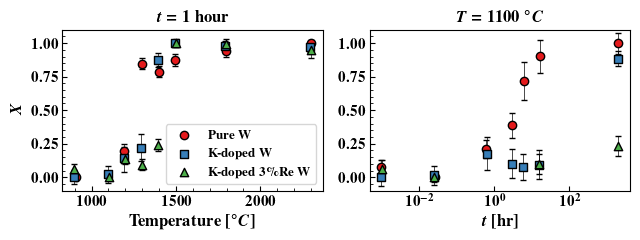

In [2]:
fig,axes = plt.subplots(ncols = 2,figsize=(6.5,2.5))
for ax in axes:
    setup_axis_default(ax)
    ax.set_ylim([-0.1,1.1])

temp_file_labels = {'Pure W': r'\textbf{Pure W}',
                    'K-doped W': r'\textbf{K-doped W}',
                    'K-doped 3%Re W': r'\textbf{K-doped 3\%Re W}'}

wdata = dict.fromkeys(temp_file_labels.keys())
colors = plt.get_cmap('Set1')(np.linspace(0,0.3,3)) 
symbols = ['o','s','^']

min_hardness = []
for dlabel,color,symbol in zip(_LABEL_TO_TEMPERATURE_FILE,colors,symbols):
    xdf = read_prepare_data(dlabel)['temperature data']
    wdata[dlabel] = xdf

    axes[0].scatter(xdf['temperature'] - 273.15, xdf['X'],facecolor = color ,marker = symbol, edgecolor ='k',
                    label = temp_file_labels[dlabel],zorder = 100)
    axes[0].errorbar(xdf['temperature'] - 273.15,xdf['X'],yerr = xdf['std'],fmt = 'none',capsize = 2,
                     elinewidth = 0.5,color = 'k')

axes[0].set_title(r'$t = 1$ \textbf{hour}',fontsize = 12)
axes[0].set_xlabel(r'\textbf{Temperature [$^\circ C$]}',fontsize = 12)
axes[0].set_ylabel('$X$',fontsize = 12)
axes[0].legend(fontsize = 9.5,loc = 'lower right')

for dlabel,color,symbol in zip(_LABEL_TO_TIME_FILE,colors,symbols):
    xdf = read_prepare_data(dlabel)['time data']
    wdata[dlabel] = pd.concat([wdata[dlabel],xdf],axis = 0)
    axes[1].scatter(xdf['time']/3600, xdf['X'],facecolor = color ,marker = symbol, edgecolor ='k',
                    label = temp_file_labels[dlabel],zorder = 100)
    axes[1].errorbar(xdf['time']/3600,xdf['X'],yerr = xdf['std'],fmt = 'none',capsize = 2,
                     elinewidth = 0.5,color = 'k')

for dlabel,df in wdata.items():
    file = DATA_DIR.joinpath('tschudia_data',dlabel + 'rx_frac.csv')
    df['temperature'] -= 273.15
    df.to_csv(file,header = True,index = True)

axes[1].set_title(r'$T = 1100$ $^\circ C$',fontsize = 12)
axes[1].set_xlabel(r'$t$ \textbf{[hr]}',fontsize = 12)
axes[1].set_xscale('log')
fig.tight_layout()
fig.savefig(GIT_IMAGE_PATH.joinpath('tshcudia_rx_fraction.svg'),bbox_inches = 'tight')

### JMAK Calibration

I'm going to demonstrate this approach using the JMAK model for the likelihood. Importantly, I fit a multivariate gaussian to the prior data of $\mathbf{c}$, that is, 

$$
p(\mathbf{c} | \mathcal{D}) = \mathcal{N}(\mu_{\mathbf{c}}, \mathbf{\Sigma}_{\mathbf{c}})
$$

where $\mu_{\mathbf{c}}$ and $\mathbf{\Sigma}_{\mathbf{c}}$ are estimated directly from [previous inference](hierarchical_recystillization_inference.ipynb) samples. I assume that 

$$
\begin{matrix}
\pi(\overline{k}) = \mathcal{U}([\overline{k}_{min},\overline{k}_{max}]) \\
\pi(\overline{t}) = \mathcal{U}([\overline{t}_{min},\overline{t}_{max}])
\end{matrix}
$$

computing the uniform ranges using the previous results again, mostly to help guide the inference by providing a vaugue estimate of the expected ranges. As before I assume that $\pi(\xi) = \text{Exp}(10)$

In [3]:

def jmak_numpyro_model(t: jnp.ndarray,
                        T: jnp.ndarray,
                        X: jnp.ndarray,
                        std: jnp.ndarray,
                        latent_param_dist: numpyro.distributions.Distribution,
                        latent_ranges) -> None:
                      
    """
    numpyro/jax numpy compatible model for the JMAK model
    """

    # priors for "latent" variables
    latent_dist = Uniform(latent_ranges[:,0],latent_ranges[:,1])
    latent_var = numpyro.sample('latent_variables',latent_dist)

    latent_param = numpyro.sample('latent_param',latent_param_dist).reshape([5,2])
    
    #priors for the model error
    sigma = numpyro.sample('sigma',Exponential(10.0))

    #apply the latent models to the sampled latent variables and latent model parameters
    a1,B1,n = latent_var[0]*latent_param[0:3,1] + latent_param[0:3,0]
    a2,B2 = latent_var[1]*latent_param[3:,1] + latent_param[3:,0]

    #compute the arrhenius parameters from the model parameters
    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)
    
    #compute the model prediction
    Xhat = 1.0 - jnp.exp(-b**n*(jnp.where(t > t_inc, t,t_inc) - t_inc)**n)

    #sample the joint likelihood
    with numpyro.plate('data',t.shape[0]):
        numpyro.sample('obs',TruncatedNormal(Xhat,sigma + std,low = 0.,high = 1.),obs = X)


In [4]:
model_name = 'JMAK_{}'
alloy_name = 'K-doped 3%Re W'

with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_samples.pkl'),'rb') as f:
    prior_samples = pickle.load(f)

#fit the prior distribution to samples from the hierarchical model
params = np.concatenate([prior_samples[a] for a in ['a1','B1','n','a2','B2']],axis = 1)
latent_param_dist = MultivariateNormal(jnp.mean(params,axis = 0),np.cov(params.T))
                        
latent_min = prior_samples['latent_variables'].min(axis = (0,1))*0.1
latent_max = prior_samples['latent_variables'].max(axis = (0,1))*10.

latent_ranges = jnp.array([latent_min,latent_max]).T
data = read_prepare_data(alloy_name)
temp_df,time_df = data['temperature data'],data['time data']

df = pd.concat([temp_df,time_df],axis = 0)
t,X,T,std = df['time'].to_numpy(),df['X'].to_numpy(),df['temperature'].to_numpy(),df['std'].to_numpy()

#setup the MCMC method
nuts_kernel = numpyro.infer.NUTS(jmak_numpyro_model,init_strategy= init_to_mean)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_samples=40000,
    num_warmup=20000,
    num_chains= 1
)

#run the MCMC
mcmc.run(rng_key_,t,T,X,std,latent_param_dist,latent_ranges)
with open(INFERENCE_PATH.joinpath(f'{alloy_name}_tpa_truncated_normal.pkl'),'wb') as f:
    pickle.dump(mcmc.get_samples(),f)

mcmc.print_summary()


ValueError: Normal distribution got invalid loc parameter.

### Maximum A Posteriori (MAP) Estimation

MAP estimation is more sensible vs. maximum likelihood, because the prior $p(\mathbf{c} | \mathcal{D})$ provides real and useful information.

In [10]:
from common_util import resampled_adam
import jax

def param_map(params: jnp.ndarray) -> Tuple[jnp.ndarray]:

    latent_param = params[0:10]
    latent_var = params[10:-1]
    log_error = params[-1]
    return latent_param,latent_var,log_error    

def model_posterior(params: jnp.ndarray,
                    t: jnp.ndarray,
                    T: jnp.ndarray,
                    X: jnp.ndarray,
                    std: jnp.ndarray,
                    latent_ranges: jnp.ndarray,
                    latent_param_dist: Distribution) -> jnp.ndarray:
    
    """
    Posterior model for the JMAK model.
    """
    # priors for "latent" variables
    latent_param_,latent_var,log_error = param_map(params)
    latent_param = latent_param_.reshape([5,2])
    latent_var_dist = Uniform(latent_ranges[:,0],latent_ranges[:,1])
    
    #priors for the model error
    sigma_dist = Exponential(10.0)

    #apply the latent models to the sampled latent variables and latent model parameters
    a1,B1,n = latent_var[0]*latent_param[0:3,1] + latent_param[0:3,0]
    a2,B2 = latent_var[1]*latent_param[3:,1] + latent_param[3:,0]

    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)
    Xhat = 1.0 - jnp.exp(-b**n*(jnp.where(t > t_inc, t,t_inc) - t_inc)**n)
    return TruncatedNormal(Xhat,jnp.exp(log_error) + std,low = 0.0,high = 1.).log_prob(X).sum() + \
            latent_var_dist.log_prob(latent_var).sum() +\
            latent_param_dist.log_prob(latent_param_).sum() +\
            sigma_dist.log_prob(jnp.exp(log_error)).sum()


model_name = 'JMAK_{}'
alloy_name = 'K-doped 3%Re W'
with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_samples.pkl'),'rb') as f:
    prior_samples = pickle.load(f)

prior_params = np.concatenate([prior_samples[a] for a in ['a1','B1','n','a2','B2']],axis = 1)
latent_param_dist = MultivariateNormal(jnp.mean(prior_params,axis = 0),np.cov(prior_params.T))
                        
latent_min = prior_samples['latent_variables'].min(axis = (0,1))*0.1
latent_max = prior_samples['latent_variables'].max(axis = (0,1))*10

latent_ranges = jnp.array([latent_min,latent_max]).T
alloy_name = 'Pure W'
data = read_prepare_data(alloy_name)
temp_df,time_df = data['temperature data'],data['time data']

df = pd.concat([temp_df,time_df],axis = 0)
t,X,T,std = df['time'].to_numpy(),df['X'].to_numpy(),df['temperature'].to_numpy(),df['std'].to_numpy()

#define optimization function
def opt_func(params: jnp.ndarray):
    return -model_posterior(params,
                            t,T,X,std,latent_ranges,latent_param_dist)

with open(INFERENCE_PATH.joinpath(f'{alloy_name}_tpa_truncated_normal.pkl'),'rb') as f:
    posterior_samples = pickle.load(f)

posterior_samples['log_error'] = jnp.log(posterior_samples['sigma'])

pkeys = ['latent_param','latent_variables','log_error']
array_samples = jnp.concat([posterior_samples[a] if posterior_samples[a].ndim == 2 else posterior_samples[a][:,jnp.newaxis] for a in pkeys],axis = 1)

NUM_SAMPLES = 50

posterior_likelihood = jax.vmap(opt_func,
                                in_axes = (0))(array_samples)

best_sample_index = np.argsort(posterior_likelihood)[:NUM_SAMPLES]

init_samples = array_samples[best_sample_index]
opt_params,posterior_value = resampled_adam(init_samples,opt_func,lr = 5e-4,opt_iter = int(2e3))
latent_param,latent_var,log_error = param_map(opt_params)

opt_params = {'latent_param': latent_param,
              'latent_variables': latent_var,
              'std': jnp.exp(log_error)}

inf_summary = {'map': opt_params,
               'mean': {key: jnp.mean(posterior_samples[key],axis = 0) for key in pkeys[:-1] + ['sigma']},
               'std': {key: jnp.std(posterior_samples[key],axis = 0) for key in pkeys[:-1] + ['sigma']}}

with open(INFERENCE_PATH.joinpath(f'{alloy_name}_tpa_map_trunc_normal.pkl'),'wb') as f:
    pickle.dump(inf_summary,f)


Optimizing: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


### Plot the Posterior Predictive Distribution

It's always good to visualize what the predicted result actually looks like so we can get a sense if its actually reasonable. The results below look acceptable, though the uncertainty is higher than previous calibrations due to the sparsity of the available data.

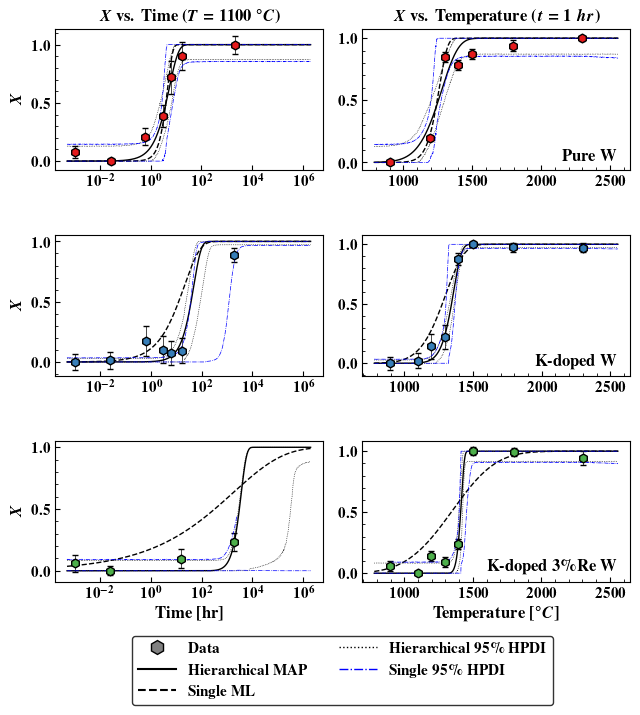

In [11]:
from numpyro.distributions import Normal, LogNormal, TruncatedNormal
from matplotlib.lines import Line2D

def jmak_model(t: np.ndarray,T:np.ndarray,latent_param: np.ndarray,latent_var: np.ndarray) -> np.ndarray:
    """
    So we can just plug in a point estimate easily
    """
    latent_param = latent_param.reshape([5,2])
    a1,B1,n = latent_var[0]*latent_param[0:3,1] + latent_param[0:3,0]
    a2,B2 = latent_var[1]*latent_param[3:,1] + latent_param[3:,0]

    b = np.exp(a1 + B1/T)
    t_inc = np.exp(a2 + B2/T)
    return 1.0 - np.exp(-b**n*(np.where(t > t_inc, t,t_inc) - t_inc)**n)

def jmak_model_seperate(t: np.ndarray,T:np.ndarray,a1: float,B1: float,a2: float,B2: float,n: float) -> np.ndarray:
    """
    So we can just plug in a point estimate easily
    """
    b = np.exp(a1 + B1/T)
    t_inc = np.exp(a2 + B2/T)
    return 1.0 - np.exp(-b**n*(np.where(t > t_inc, t,t_inc) - t_inc)**n)

def jmak_numpyro_model_seperate(t: jnp.ndarray,
                      T: jnp.ndarray,
                      X: jnp.ndarray,
                      std: jnp.ndarray,
                      pmean: jnp.ndarray,
                      pstd: jnp.ndarray) -> None:
    """
    numpyro/jax numpy compatible model for the JMAK model
    """

    # priors
    a1 = numpyro.sample('a1',Normal(pmean[0],pstd[0]))
    a2 = numpyro.sample('a2',Normal(pmean[2],pstd[2]))
    B1 = numpyro.sample('B1',Normal(pmean[1],pstd[1]))
    B2 = numpyro.sample('B2',Normal(pmean[3],pstd[3]))
    n = numpyro.sample('n',LogNormal(pmean[4]/2))

    sigma = numpyro.sample('sigma',numpyro.distributions.Exponential(10.0))

    # arrhenius equations
    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)

    #model prediction
    Xhat = 1.0 - jnp.exp(-b**n*(jnp.where(t > t_inc, t,t_inc) - t_inc)**n)
    
    # likelihood
    with numpyro.plate("data", t.shape[0]):
        numpyro.sample('obs',TruncatedNormal(Xhat,scale = sigma + std,low = 0.0,high = 1.0),obs = X)

def plot_posterior_predictive(t: jnp.ndarray,
                              temperature : jnp.ndarray,
                              x: jnp.ndarray,
                              ax: plt.Axes,
                              posterior_predictive: Callable,
                              point_estimate: pd.DataFrame,
                              pred_color: str = 'k',
                              style: str = '-'): 
    
    
    """
    helper function to plot posterior prediction summaries.
    """
    #sample from the posterior predictive
    predictions = posterior_predictive(rng_key_,t  = jnp.array(t),
                                    T =  jnp.ones_like(t)*temperature,
                                    X = None,
                                    std = jnp.zeros_like(t),
                                    latent_param_dist = MultivariateNormal(np.empty(5),np.eye(5)),
                                    latent_ranges = latent_ranges)['obs']

    #Estimate using mean parameters
    point_pred = jmak_model(t,temperature,
                         point_estimate['latent_param'],
                         point_estimate['latent_variables'])

    #Confidence Intervals using HPDI
    lower,upper = numpyro.diagnostics.hpdi(predictions,0.95)
    lower,upper = np.clip(lower,0,1),np.clip(upper,0,1)

    #Visualize the results using mean + HPDI
    ax.plot(x,point_pred,color = pred_color,lw = 1.0,ls = style)
    ax.plot(x,lower,color = 'k',lw = 0.5,ls = ':')
    ax.plot(x,upper,color = 'k',lw = 0.5,ls = ':')  

def plot_time_posterior_prediction(ax: plt.Axes,
                              posterior_predictive: Callable,
                              point_estimate: pd.DataFrame,
                              exp_data: pd.DataFrame,
                              style: str = '-',
                              pred_color: str = 'k') -> None:
    
    t = jnp.logspace(np.log10(exp_data['time'].min()*0.5),
                    np.log10(exp_data['time'].max()*1e3),1000)

    temperature = exp_data['temperature'].iloc[0]*jnp.ones_like(t)

    plot_posterior_predictive(t,temperature, t/3600,ax,posterior_predictive,point_estimate,pred_color,style)

def plot_temperature_posterior_prediction(ax: plt.Axes,
                                          posterior_predictive: Callable,
                                          point_estimate: pd.DataFrame,
                                          exp_data: pd.DataFrame,
                                        style: str = '-',
                                        pred_color: str = 'k') -> None:
    
    temperature = np.linspace(exp_data['temperature'].min()*0.9,exp_data['temperature'].max()*1.1,1000)
    t = exp_data['time'].iloc[0]*jnp.ones_like(temperature)

    plot_posterior_predictive(t,temperature,temperature - 273.15,ax,posterior_predictive,point_estimate,pred_color,style)

def plot_posterior_prediction_seperate(ax: plt.Axes,
                              model_func: Callable,
                              ml_est: np.ndarray,
                              posterior_predictive: numpyro.infer.Predictive,
                              x: np.ndarray,
                              time: np.ndarray,
                              temperature: np.ndarray,
                              style: str = '-',
                              pred_color: str = 'k') -> None:
    
    """
    helper function to plot posterior prediction summaries.
    """

    #sample from the posterior predictive
    predictions = posterior_predictive(rng_key_,t = time,
                                                    T = temperature,
                                                    X = None,
                                                    std = jnp.zeros_like(time),
                                                    pmean = np.empty_like(ml_est),
                                                    pstd = np.empty_like(ml_est))

    #Estimate using ML parameters
    ml_pred = model_func(time,jnp.ones_like(time)*temperature,
                        *ml_est)

    #Confidence Intervals using HPDI
    lower,upper = numpyro.diagnostics.hpdi(predictions['obs'],0.95)

    #Visualize the results using ML + HPDI
    ax.plot(x,ml_pred,color = pred_color,lw = 1.0,ls = style)
    ax.plot(x,lower,color = 'blue',lw = 0.5,ls = '-.')
    ax.plot(x,upper,color = 'blue',lw = 0.5,ls = '-.')  

def plot_temperature_posterior_prediction_seperate(ax: plt.Axes,
                              model_func: Callable,
                              ml_est: np.ndarray,
                              posterior_predictive: numpyro.infer.Predictive,
                              exp_data: pd.DataFrame,
                              style: str = '-',
                              pred_color: str = 'k') -> None:
    
    temperature = np.linspace(exp_data['temperature'].min()*0.9,exp_data['temperature'].max()*1.1,1000)
    t = exp_data['time'].iloc[0]*jnp.ones_like(temperature)

    plot_posterior_prediction_seperate(ax,model_func,ml_est,posterior_predictive,
                                       temperature - 273.15,t,temperature,pred_color = pred_color,style = style)

def plot_time_posterior_prediction_seperate(ax: plt.Axes,
                                            model_func: Callable,
                                            ml_est: np.ndarray,
                                            posterior_predictive: numpyro.infer.Predictive,
                                            exp_data: pd.DataFrame,
                                            style: str = '-',
                                            pred_color: str = 'k') -> None:

    t = jnp.logspace(np.log10(exp_data['time'].min()*0.5),
                    np.log10(exp_data['time'].max()*1e3),1000)

    temperature = exp_data['temperature'].iloc[0]*jnp.ones_like(t)
    plot_posterior_prediction_seperate(ax,model_func,ml_est,posterior_predictive,
                                       t/3600,t,temperature,pred_color = pred_color,style = style)


def plot_time_experimental_data(ax: plt.Axes,
                           data: pd.DataFrame,
                           color: str,
                           first_label = True,
                           make_label = True) -> None:
    
    """
    helper function to plot data.
    """

    temperature = data['temperature'].iloc[0]
    label = r'\textbf{$T = ' + f'{temperature}$' + r' [$^\circ C $]}' if first_label else  r'\textbf{' rf'${temperature}$' + r' [$^\circ C $]}'
    #plot the data and error bars
    ax.scatter(data['time']/3600,data['X'],facecolor = color,s = 40,
            edgecolor = 'k',zorder = 100,marker = 'h',
            label = label if make_label else None)
    ax.errorbar(data['time']/3600,data['X'],yerr = data['std'],color = 'k',
                fmt = 'none',capsize = 2,elinewidth = 0.5)

def plot_temperature_experimental_data(ax: plt.Axes,
                                       data: pd.DataFrame,
                                       color: str,
                                       first_label = True,
                                       make_label = True) -> None:
    
    """
    helper function to plot data.
    """

    time = data['time'].iloc[0]
    label = r'\textbf{$t = ' + f'{time/3600}$' + r' [hr]}' if first_label else  r'\textbf{' rf'${time/3600}$' + r' [hr]}'
    #plot the data and error bars
    ax.scatter(data['temperature'] - 273.15,data['X'],facecolor = color,s = 40,
            edgecolor = 'k',zorder = 100,marker = 'h',
            label = label if make_label else None)
    ax.errorbar(data['temperature'] - 273.15,data['X'],yerr = data['std'],color = 'k',
                fmt = 'none',capsize = 2,elinewidth = 0.5)

model_name = 'JMAK_{}'
alloy_name = 'K-doped 3%Re W'
fig,axes_ = plt.subplot_mosaic("""AB
                           CD
                           EF
                           GG""",figsize = (6.5,7.25),height_ratios= [1,1,1,0.3333333])

axes = np.array([axes_[a] for a in ['A','B','C','D','E','F']]).reshape(3,2)
lax = axes_['G']
lax.axis('off')

legend = lax.legend(handles = [Line2D([],[],marker = 'h', markersize = 10,
                             markeredgecolor = 'k',lw = 0.0,markerfacecolor = 'grey',label = r'\textbf{Data}'),
                     Line2D([],[],lw = 1.5,ls = '-',color = 'k',label = r'\textbf{Hierarchical MAP}'),
                     Line2D([],[],lw = 1.5,ls = '--',color = 'k',label = r'\textbf{Single ML}'),
                     Line2D([],[],lw = 1.0,ls = ':',color = 'k',label = r'\textbf{Hierarchical 95\% HPDI}'),
                     Line2D([],[],lw = 1.0,ls = '-.',color = 'blue',label = r'\textbf{Single  95\% HPDI}')],
                        loc = 'center',fontsize = 11,frameon = True,ncols = 2,
                        handlelength = 2.5)
frame = legend.get_frame()
frame.set_linewidth(1.0)
frame.set_edgecolor('k')

colors = plt.get_cmap('Set1')(np.linspace(0,0.3,3)) 
for ax in axes.ravel():
    setup_axis_default(ax)

for i,alloy_name in enumerate(['Pure W','K-doped W','K-doped 3%Re W']):
    
    #structural model pprediction
    with open(INFERENCE_PATH.joinpath(f'{alloy_name}_tpa.pkl'),'rb') as f:
        posterior_samples = pickle.load(f)
        
    with open(INFERENCE_PATH.joinpath(f'{alloy_name}_tpa_map.pkl'),'rb') as f:
        point_estimate = pickle.load(f)['map']

    posterior_predictive = numpyro.infer.Predictive(jmak_numpyro_model,
                                                    posterior_samples= posterior_samples)

    # Phase fraction vs. time
    time_df = read_prepare_data(alloy_name)['time data']
    plot_time_posterior_prediction(axes[i,0],posterior_predictive,point_estimate,time_df,style = '-',pred_color = 'k')
    plot_time_experimental_data(axes[i,0],time_df,colors[i],make_label = i == 0)
    axes[i,0].set_ylabel(r'$X$',fontsize = 12)
    axes[i,0].set_xscale('log')

    #Phase fraction vs. temperature
    temp_df = read_prepare_data(alloy_name)['temperature data']
    plot_temperature_posterior_prediction(axes[i,1],posterior_predictive,point_estimate,temp_df,style = '-',pred_color = 'k')
    plot_temperature_experimental_data(axes[i,1],temp_df,colors[i],make_label = i == 2)


    with open(INFERENCE_PATH.joinpath(f'{alloy_name}_single_trunc_normal_samples.pkl'),'rb') as f:
        posterior_samples = pickle.load(f)

    inf_summary = pd.read_csv(INFERENCE_PATH.joinpath(model_name.format(f'{alloy_name}_single_trunc_normal_params.csv')),index_col = 0)
    a1,B1,a2,B2,n,_ = inf_summary.loc[['a1','B1','a2','B2','n','sigma'],'ml'].to_numpy()
    posterior_predictive = numpyro.infer.Predictive(jmak_numpyro_model_seperate,
                                                    posterior_samples= posterior_samples)

    # Phase fraction vs. time
    time_df = read_prepare_data(alloy_name)['time data']
    plot_time_posterior_prediction_seperate(axes[i,0],jmak_model_seperate,np.array([a1,B1,a2,B2,n]),
                                           posterior_predictive,time_df,style = '--',pred_color = 'k')
    temp_df = read_prepare_data(alloy_name)['temperature data']
    plot_temperature_posterior_prediction_seperate(axes[i,1],jmak_model_seperate,np.array([a1,B1,a2,B2,n]),
                                           posterior_predictive,temp_df,style = '--',pred_color = 'k')
    
    axes[i,1].text(0.95, 0.05, temp_file_labels[alloy_name] , ha='right', va='bottom', transform=axes[i,1].transAxes, fontsize=12)


axes[0,0].set_title(r'\textbf{$X$ vs. Time ($T = 1100 \ ^\circ C$)}',fontsize = 12)
axes[0,1].set_title(r'\textbf{$X$ vs. Temperature ($t = 1 \ hr$)}',fontsize = 12)
axes[2,0].set_xlabel(r'\textbf{Time [hr]}',fontsize = 12)
axes[2,1].set_xlabel(r'\textbf{Temperature [$^\circ C$]}',fontsize = 12)

fig.tight_layout()
fig.savefig(GIT_IMAGE_PATH.joinpath('extensions_alloys_phase_fraction_vs_time_temperature_trunc_normal.svg'),bbox_inches = 'tight')

### Visualize KDE Posteriors

It's helpful to visually compare the marginal posteriors of $\overline{k}^{new}$ of these tungsten alloys with previous $\overline{k}$ for pure tungsten data to get a sense of the recrystilization resistance demonstrated.

With the exception of the K-doped 3% Re alloy, the tungsten alloys actually exhibit _worse_ recrystilization resitance than any of the pure W alloys encountered previously.

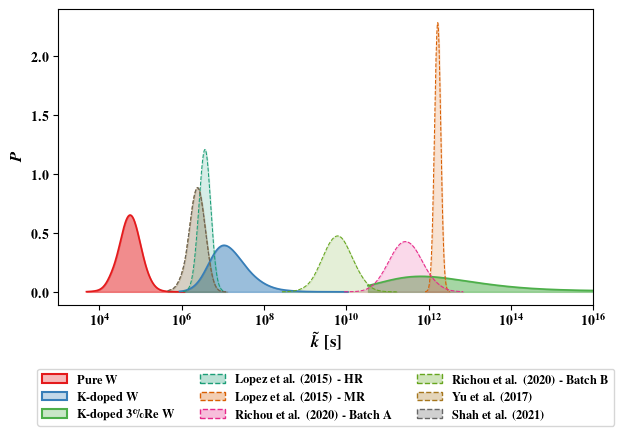

In [4]:
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
from common_util import _FILE_TO_LABEL as file_to_label

model_name = 'JMAK_{}'
fig,axes = plt.subplot_mosaic("""
                              A
                              B
                              """,
                              height_ratios= [1,0.2],
                              figsize = (6.5,4.5))

colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(temp_file_labels)))

legend_axes = axes['B']
ax = axes['A']
colors = plt.get_cmap('Set1')(np.linspace(0,0.3,3)) 

for i,alloy_name in enumerate(_LABEL_TO_TEMPERATURE_FILE.keys()):
    with open(INFERENCE_PATH.joinpath(f'{alloy_name}_tpa_truncated_normal.pkl'),'rb') as f:
        posterior_samples = pickle.load(f)['latent_variables']


    kde = gaussian_kde(posterior_samples[:,0],bw_method = 0.35)
    x = np.linspace(np.min(posterior_samples[:,0]),
                    np.max(posterior_samples[:,0]),200)
    pde_plot = kde(x)
    ax.plot(np.exp(x),pde_plot,color = colors[i],lw = 1.25)
    ax.fill_between(np.exp(x),pde_plot,0,alpha = 0.5,color = colors[i])

legend_patches  = [mpatches.Patch(facecolor = tuple(list(color)[:-1] + [0.3]),edgecolor  = color,
                                label = temp_file_labels[file],lw = 1.5) for color,file in zip(colors,_LABEL_TO_TEMPERATURE_FILE.keys())]

with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_samples.pkl'),'rb') as f:
    posterior_samples = pickle.load(f)['latent_variables']

colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(file_to_label)))
for i,alloy_name in enumerate(file_to_label.keys()):

    kde = gaussian_kde(posterior_samples[:,i,0],bw_method = 0.35)
    x = np.linspace(np.min(posterior_samples[:,i,0]),
                    np.max(posterior_samples[:,i,0]),200)
    
    pde_plot = kde(x)
    ax.plot(np.exp(x),pde_plot,color = colors[i],lw = 0.75,ls = '--')
    ax.fill_between(np.exp(x),pde_plot,0,alpha = 0.175,color = colors[i])

ax.set_xscale('log')
ax.set_xlabel(r'$\tilde{k}$ \textbf{[s]}',fontsize = 12)
for k in range(2):
    ax.set_ylabel(r'$P$',fontsize = 12)

legend_patches.extend([
    mpatches.Patch(facecolor = tuple(list(color)[:-1] + [0.3]),edgecolor  = color,
                   label = r'\textbf{' + file_to_label[file] + '}',lw = 1.,ls = '--') for color,file in zip(colors,file_to_label.keys())
])

ax.set_xlim([10**3,10**16])
legend_axes.legend(handles = legend_patches,fontsize = 9,ncol = 3,loc = 'center')
legend_axes.axis('off')
fig.tight_layout()
fig.savefig(GIT_IMAGE_PATH.joinpath('latent_variable_posterior_extension_truncated_normal.svg'),bbox_inches = 'tight')

### $t_{1/2}$ comparison between alloys

Helpful in determining if these alloys are "good" or not.

K-doped 3%Re W RT: 1078.7 [1057.6,1201.2]


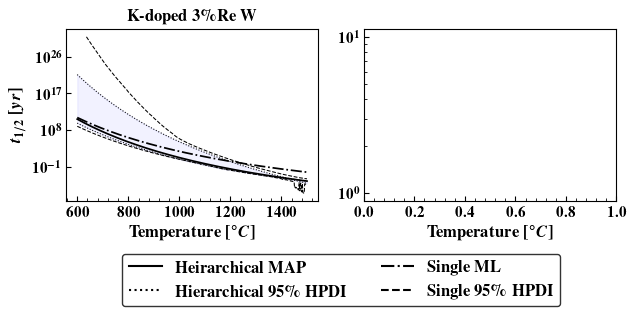

In [6]:
from jax import vmap
from jax import random
from numpy.polynomial import Polynomial
from scipy.optimize import bisect

rng_key = random.PRNGKey(136)
model_name = 'JMAK_{}'

def sample_jmak_model_time(X: float,
                            T: jnp.ndarray,
                            a1: jnp.ndarray,
                            a2: jnp.ndarray,
                            B1: jnp.ndarray,
                            B2: jnp.ndarray,
                            n: jnp.ndarray,
                            sigma: jnp.ndarray = None) -> np.ndarray:
    
    error = 0.0 if sigma is None else TruncatedNormal(0,sigma,low = 0,high  =1).sample(random.PRNGKey(B1.astype(int)))
    X = jnp.clip(X - error,0.05,3)

    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)
    return 1.0/b*jnp.log(1./(1. - X))**(1/n) + t_inc  

with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_samples.pkl'),'rb') as f:
    prior_samples = pickle.load(f)

def vmapped_sample_model_time(model_time: Callable,
                                X: float,
                                T: jnp.ndarray,
                                a1: jnp.ndarray,
                                a2: jnp.ndarray,
                                B1: jnp.ndarray,
                                B2: jnp.ndarray,
                                n: jnp.ndarray,
                                sigma: jnp.ndarray = None) -> np.ndarray:
    
    def single_temperature(T_: jnp.ndarray) -> np.ndarray:
        return vmap(model_time,in_axes = (None,None,0,0,0,0,0,0))(X,T_,a1,a2,B1,B2,n,sigma)

    return vmap(single_temperature,in_axes = (0))(T)

def posterior_latent_model(samples: Dict[str,np.ndarray]):
    latent_var,latent_param = samples['latent_variables'],samples['latent_param']
    if latent_var.ndim == 1:
        latent_var = latent_var[...,np.newaxis]
        latent_param = latent_param[...,np.newaxis]
    elif latent_var.ndim == 2:
        latent_var = latent_var.swapaxes(0,-1)
        latent_param = latent_param.swapaxes(0,-1)
    
    latent_param = latent_param.reshape([5,2,-1])
    
    a1,B1,n = latent_var[0,...]*latent_param[0:3,1,...] + latent_param[0:3,0,...]
    a2,B2 = latent_var[1,...]*latent_param[3:,1,...] + latent_param[3:,0,...]

    return a1,a2,B1,B2,n

def prior_latent_model(summary_df: pd.DataFrame,
                       model_index: int):
    a1 = summary_df['a1'][0] + summary_df['a1'][1]*summary_df['latent_variables'][model_index,0] 
    B1 = summary_df['B1'][0] + summary_df['B1'][1]*summary_df['latent_variables'][model_index,0]
    n = summary_df['n'][0] + summary_df['n'][1]*summary_df['latent_variables'][model_index,0]
    a2 = summary_df['a2'][0] + summary_df['a2'][1]*summary_df['latent_variables'][model_index,1]
    B2 = summary_df['B2'][0] + summary_df['B2'][1]*summary_df['latent_variables'][model_index,1]
    return a1,a2,B1,B2,n

def estimate_RT(sampled_time: np.ndarray,
                map_time: np.ndarray,
                temperature: np.ndarray,
                target_time: float,
                poly_order: int = 2):


    lower,upper = numpyro.diagnostics.hpdi(sampled_time.T,0.95)
    RTs = []
    for t in [map_time,lower,upper]:
        poly = Polynomial.fit(temperature,np.log(t),deg = poly_order)
        temp = bisect(lambda x: np.exp(poly(x)) - target_time,temperature.min(),temperature.max())
        RTs.append(temp)

    return np.array(RTs)




alloy_name = 'K-doped 3%Re W'
X = 0.95
SECONDS_TO_HOURS = 3600.0
HOURS_TO_YEAR = 24.0*365.0
SECONDS_TO_YEAR = SECONDS_TO_HOURS*HOURS_TO_YEAR

fig,axes_ = plt.subplot_mosaic("""AB
                               CC""",figsize = (6.5,3.25),height_ratios= [1,0.2])
colors = plt.get_cmap('Set1')(np.linspace(0,0.3,3)) 
axes,legend_ax = np.array([axes_[a] for a in ['A','B']]),axes_['C']

for ax in axes:
    setup_axis_default(ax)
    ax.set_xlabel(r'\textbf{Temperature [$^\circ C$]}',fontsize = 12)

axes[0].set_ylabel(r'\textbf{$t_{1/2}$ [$yr$]}',fontsize = 12)

t_ranges = [(600,1500),(600,2000)]
for i,(ax,alloy_name,tr) in enumerate(zip(axes,[r'K-doped 3%Re W'],t_ranges)):
    
    ax.set_title(r'\textbf{' + alloy_name.replace('%',r'\%') + '}',fontsize = 12)
    #Map Estimate
    with open(INFERENCE_PATH.joinpath(f'{alloy_name}_tpa_map_trunc_normal.pkl'),'rb') as f:
        inf_summary = pickle.load(f)['map']

    temperature = np.linspace(tr[0],tr[1],500) + 273.15
    map_params = posterior_latent_model(inf_summary)
    t = sample_jmak_model_time(X,jnp.array(temperature),*map_params)
    ax.plot(temperature - 273.15,t/SECONDS_TO_YEAR,lw = 1.25, color = 'k',ls = '-')

    #Confidence Intervals
    with open(INFERENCE_PATH.joinpath(f'{alloy_name}_tpa_truncated_normal.pkl'),'rb') as f:
        posterior_samples = pickle.load(f)
    
    param_samples = posterior_latent_model(posterior_samples)
    sampled_t = vmapped_sample_model_time(sample_jmak_model_time,X,jnp.array(temperature),*param_samples,sigma = posterior_samples['sigma'])
    lower,upper = numpyro.diagnostics.hpdi(sampled_t.T,0.95)
    ax.fill_between(temperature - 273.15,lower/SECONDS_TO_YEAR,upper/SECONDS_TO_YEAR,alpha = 0.05,color = 'blue')
    ax.plot(temperature - 273.15,lower/SECONDS_TO_YEAR,color = 'k',lw = 0.75,ls = ':')
    ax.plot(temperature - 273.15,upper/SECONDS_TO_YEAR,color = 'k',lw = 0.75,ls = ':')
    
    RT = np.round(estimate_RT(sampled_t, t, temperature,SECONDS_TO_YEAR) - 273.15,1)
    print('{} RT: {} [{},{}]'.format(alloy_name,RT[0],RT[1],RT[2]))

    #Single ML Estimate
    with open(INFERENCE_PATH.joinpath(f'{alloy_name}_single_trunc_normal_samples.pkl'),'rb') as f:
        posterior_samples = pickle.load(f)

    inf_summary = pd.read_csv(INFERENCE_PATH.joinpath(model_name.format(f'{alloy_name}_single_trunc_normal_params.csv')),index_col = 0)
    a1,B1,a2,B2,n,_ = inf_summary.loc[['a1','B1','a2','B2','n','sigma'],'ml'].to_numpy()
    
    t = sample_jmak_model_time(X,jnp.array(temperature),a1,a2,B1,B2,n)
    ax.plot(temperature - 273.15,t/SECONDS_TO_YEAR,lw = 1.25, color = 'k',ls = '-.')
    #Confidence Intervals
    sampled_t = vmapped_sample_model_time(sample_jmak_model_time,X,jnp.array(temperature),
                                              *[posterior_samples[a] for a in ['a1','a2','B1','B2','n']],
                                              sigma = posterior_samples['sigma'])
    lower,upper = numpyro.diagnostics.hpdi(sampled_t.T,0.95)
    ax.plot(temperature - 273.15,lower/SECONDS_TO_YEAR,color = 'k',lw = 0.75,ls = '--')
    ax.plot(temperature - 273.15,upper/SECONDS_TO_YEAR,color = 'k',lw = 0.75,ls = '--')

legend_patches = [
    plt.Line2D([0], [0], color='k', lw=1.5, ls = '-',label = r'\textbf{Heirarchical MAP}'),
    plt.Line2D([0], [0], color='k', lw=1.5, ls = ':',label = r'\textbf{Hierarchical 95\% HPDI}'),
    plt.Line2D([0], [0], color='k', lw=1.5, ls = '-.',label = r'\textbf{Single ML}'),
    plt.Line2D([0], [0], color='k', lw=1.5, ls = '--',label = r'\textbf{Single 95\% HPDI}'),
]

legend = legend_ax.legend(handles = legend_patches,loc = 'center',fontsize = 12.0,frameon = True,ncol = 2)
legend_ax.axis('off')
frame = legend.get_frame()
frame.set_linewidth(1.0)
frame.set_edgecolor('k')
for ax in axes:
    ax.set_yscale('log')
fig.tight_layout()
#fig.savefig(GIT_IMAGE_PATH.joinpath('half_rx_time_trunc_normal.svg'),bbox_inches = 'tight')